In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt
import time

from model import ConvNet
from CustomDataset import get_dataset

[nltk_data] Downloading package punkt to /nfs4/ushashi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
random.seed(20)
np.random.seed(20)


NUM_MAPS = 5*20*20
LEARNINGRATE = 8e-3
GAMMA = 0.9

BATCHSIZE = 256
NUMEPOCHS = 11

LOG_SOFTMAX_VALUES = False

dset = get_dataset('20news-bydate-test')

FILE = 'weights/Model_quicksave40.pt'


class_names = dset.classes
print(class_names)


rand_files = random.sample(range(len(dset)), NUM_MAPS)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

model = ConvNet(LOG_SOFTMAX_VALUES)
model.load_state_dict(torch.load(FILE))
model.eval()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
print('Building model..')	
model.to(device)
print('Model Built.')



print('Printing Parameters')
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

print('---Printing Parameters Finished!---')

Running on cuda:0
Building model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
---Printing Parameters Finished!---


In [4]:
def comp_loss(mod,org,h):
    
    
    ### Loss 1
    z = torch.mean((mod[:,h]-org[:,h])**2)
    
    '''
    ### Loss 2
    z = torch.mean((mod[:,:]-org[:,:])**2)
    '''
    
    '''
    ### Loss 3
    z = mod-org
    z[:,h] = F.relu(org[:,h]-mod[:,h])
    z = torch.mean((F.relu(z))**2)
    '''
    
    return z

In [5]:
def GenRelMap(x, num_iters=400, lr =8e-3, gam = 0.95 , lamb = 750 ):

    flag = True
    dirr = 0
    inc = 1.0
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
    
    #print(x_input.shape)
    #print(highest_dim)
    while flag:
        
        s = 0.1*np.random.rand(1,x.shape[2],1)
        #s = 0.5*np.ones((1,x.shape[2],1)) 
        s = torch.as_tensor(s.astype(np.float32)).to(device)
        s = torch.autograd.Variable(s, requires_grad=True)
    
        optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)

        
        for i in range(num_iters):

            n = torch.as_tensor(np.random.normal(size=(BATCHSIZE, *(x.shape[1:]))).astype(np.float32)).to(device)
            n = n.clamp_(-1,1)

            data_input = (x_input-n)*s+n
            out = model(data_input)

            loss = 0.5*comp_loss(out,x_out,highest_dim)+lamb*torch.mean(torch.abs(s))

            '''
            if (i)%50==0:
                print("Net loss:{:.5f}, Distort Error:{:.5f}, L1:{:.8f}".format(loss.data.item(),
                                                                      0.5*comp_loss(out,x_out,highest_dim).data.item(),
                                                                      torch.mean(torch.abs(s)).data.item()))
                print(list(np.argmax(out.detach().cpu().numpy(), axis=1)).count(highest_dim)*100.0/BATCHSIZE)
                #print(s.mean())
                #print(loss.data.item())
                #print(0.5*comp_loss(out,x_out,highest_dim).data.item())
            '''
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                s += s.clamp_(0,1) - s

                #print(s)
                #print(s.grad)
                #print(0.5*torch.mean((out[:, highest_dim]-x_out[:, highest_dim])**2).data.item())
                #print(lamb*torch.mean(torch.abs(s)).data.item())

            scheduler.step()
            
        print(s.detach().cpu().numpy().mean())
        if s.detach().cpu().numpy().mean()>0.12:
            if dirr<0:
                inc = inc/2
                print('A')
            
            lamb = lamb*(1+inc)
            dirr = 1
            print('1')
        
        elif s.detach().cpu().numpy().mean()<0.05:
            if dirr > 0:
                inc = inc/2
                print('B')
                
            lamb = lamb/(1+inc)
            dirr = -1
            print('-1')
            
        else:
            break
        
    
    return s.detach().cpu().numpy()

In [ ]:
import time

rmap = [None]*20
wds = [None]*20
pths = [None]*20

for x in range(len(rmap)):
    rmap[x] = [0]*7
    wds[x] = [0]*7
    pths[x] = [0]*7
    
counter = [0]*20
_ = 0

while not all(x == 7 for x in counter):
    
    start_time = time.time()
    
    e = dset.get_words_list(rand_files[_])
    
    if len(e)<25 or len(e)>1000:
        _ += 1
        continue
    
    sample, target, path = dset[rand_files[_]]
    sample = dset.get_custom_matrix(rand_files[_])
    sample = sample[None,None,:,:]
    
    x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
    x_out = model(x_input.clone()).detach().cpu()
    
    _ += 1
    
    if np.argmax(x_out) != target:    
        continue
        
    if counter[target] == 7:
        continue
    
    print(_)
    print(target)
    print(counter)
    print(sample.shape)
    #print(path)
    
    rmap[target][counter[target]] = GenRelMap(sample, num_iters=401, lamb=700, gam=0.98, lr = 4e-3)[0,:,0]
    wds[target][counter[target]] = e
    pths[target][counter[target]] = path
    
    counter[target] += 1
    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    print(time_el)

1
19
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(1, 1, 127, 300)
0.03258088
-1
0.1800488
A
1
0.11298314
550
2
15
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
(1, 1, 687, 300)
0.16213487
1
0.04678311
B
-1
0.12739554
A
1
0.08697467
3938
3
14
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
(1, 1, 151, 300)
0.005161649
-1
0.16270804
A
1
0.064652525
674
8
3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
(1, 1, 239, 300)
0.15039535
1
0.0023670217
B
-1
0.07368092
1037
9
5
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
(1, 1, 29, 300)
0.04029866
-1
0.17806393
A
1
0.120501205
1
0.020039592
B
-1
0.07204842
214
10
14
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
(1, 1, 219, 300)
0.09314172
315
11
13
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1]
(1, 1, 83, 300)
9.587218e-09
-1
8.844882e-05
-1
0.014825932
-1
0.10127918
480
14
2
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1]
(1, 1, 

In [8]:

print(_)

while not all(x == 7 for x in counter):
    
    start_time = time.time()
    
    e = dset.get_words_list(rand_files[_])
    
    if len(e)<25 or len(e)>1000:
        _ += 1
        continue
    
    sample, target, path = dset[rand_files[_]]
    sample = dset.get_custom_matrix(rand_files[_])
    sample = sample[None,None,:,:]
    
    x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
    x_out = model(x_input.clone()).detach().cpu()
    
    _ += 1
    
    if np.argmax(x_out) != target:    
        continue
        
    if counter[target] == 7:
        continue
    
    print(_)
    print(target)
    print(counter)
    print(sample.shape)
    #print(path)
    
    rmap[target][counter[target]] = GenRelMap(sample, num_iters=401, lamb=700, gam=0.98, lr = 4e-3)[0,:,0]
    wds[target][counter[target]] = e
    pths[target][counter[target]] = path
    
    counter[target] += 1
    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    print(time_el)


115
116
3
[1, 2, 5, 6, 5, 5, 3, 4, 5, 4, 2, 2, 1, 6, 6, 2, 2, 4, 1, 4]
(1, 1, 128, 300)
0.17415114
1
0.006778859
B
-1
0.11198625
550
117
19
[1, 2, 5, 7, 5, 5, 3, 4, 5, 4, 2, 2, 1, 6, 6, 2, 2, 4, 1, 4]
(1, 1, 551, 300)
0.05337072
786
118
17
[1, 2, 5, 7, 5, 5, 3, 4, 5, 4, 2, 2, 1, 6, 6, 2, 2, 4, 1, 5]
(1, 1, 213, 300)
0.038272087
-1
0.1582541
A
1
0.09534472
919
119
1
[1, 2, 5, 7, 5, 5, 3, 4, 5, 4, 2, 2, 1, 6, 6, 2, 2, 5, 1, 5]
(1, 1, 65, 300)
0.08534621
94
124
0
[1, 3, 5, 7, 5, 5, 3, 4, 5, 4, 2, 2, 1, 6, 6, 2, 2, 5, 1, 5]
(1, 1, 265, 300)
0.009989181
-1
0.12466724
A
1
0.05391052
1144
125
17
[2, 3, 5, 7, 5, 5, 3, 4, 5, 4, 2, 2, 1, 6, 6, 2, 2, 5, 1, 5]
(1, 1, 258, 300)
0.031350475
-1
0.15138142
A
1
0.088766366
1122
126
13
[2, 3, 5, 7, 5, 5, 3, 4, 5, 4, 2, 2, 1, 6, 6, 2, 2, 6, 1, 5]
(1, 1, 71, 300)
2.0949736e-08
-1
0.019429399
-1
0.1046715
308
127
16
[2, 3, 5, 7, 5, 5, 3, 4, 5, 4, 2, 2, 1, 7, 6, 2, 2, 6, 1, 5]
(1, 1, 298, 300)
8.3199775e-06
-1
0.039485443
-1
0.14738467
A
1
0.095716104
1724


0.030871525
B
-1
0.1641564
A
1
0.10419341
418
287
18
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 4, 7, 7, 7, 7, 7, 6, 7]
(1, 1, 613, 300)
2.8190502e-08
-1
0.0030998033
-1
0.04604177
-1
0.09403296
3499
306
0
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 4, 7, 7, 7, 7, 7, 7, 7]
(1, 1, 46, 300)
0.009872417
-1
0.10270862
134
309
10
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 4, 7, 7, 7, 7, 7, 7, 7]
(1, 1, 62, 300)
0.059264246
88
336
10
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 4, 7, 7, 7, 7, 7, 7, 7]
(1, 1, 250, 300)
0.06756293
362
481
12
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7]
(1, 1, 146, 300)
0.20584323
1
0.064583786
418
510
12
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7]
(1, 1, 709, 300)
0.19937508
1
0.13658947
1
0.0010473863
B
-1
0.068245284
4055
528
12
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7]
(1, 1, 152, 300)
0.20879479
1
0.10228604
434


In [9]:
np.save('data_loss1_seed20.npy',[rmap,wds,pths])

In [ ]:
[rmap,wds,pths] = np.load('data.npy',allow_pickle=True)

In [10]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

20news-bydate-test/rec.sport.baseball/104686
0.074276105
Modified


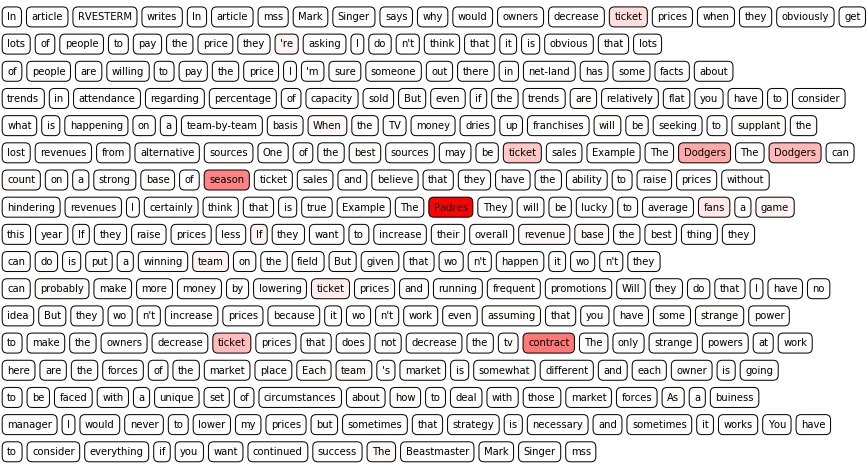

In [11]:

no = 3
cls = 9
print(pths[cls][no])
print(rmap[cls][no].mean())
if rmap[cls][no].mean() > 0.05:
    plot_text_heatmap(wds[cls][no],(rmap[cls][no]/np.max(rmap[cls][no]))**8)
    print("Modified")
else:
    plot_text_heatmap(wds[cls][no],rmap[cls][no])

In [12]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D
from keras.models import Model
import tensorflow as tf


print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1280,(5,300),activation='relu', name='conv1')(inp)
    
    # Reshaping to (BCHW)
    x = GlobalMaxPool2D('channels_last')(x)
    # Reshaping to (BCHW)
    #x = Lambda(lambda x: K.permute_dimensions(x, (0, 3, 1, 2)))(x)
    #x = Flatten()(x)
    z = Dense(160,name='fc1')(x)
    out = Dense(20,name='fc2')(z)
    k_model = Model(inp, out)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    #print(x)
    #print(l)
    #print(x.find('.'))
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

Using TensorFlow backend.


channels_last
['conv1' 'fc1' 'fc2']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1280)     1921280   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 160)               204960    
_________________________________________________________________
fc2 (Dense)                  (None, 20)                3220      
Total params: 2,129,460
Trainable params: 2,129,460
Non-trainable params: 0
_________________________________________________________________


In [13]:
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

In [14]:
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor']
kwargs = [{}, {}, {}, {}]

In [15]:
analyzers = []

for method, kws in zip(methods, kwargs):
    #print(method)
    analyzer = innvestigate.create_analyzer(method, k_model, **kws)
    #analyzer.fit(sample[None,:,:,None], batch_size=256, verbose=1)
    analyzers.append(analyzer)

In [16]:
from keras.layers import Softmax
import time

test_sample_paths = [pths[6][6]]

test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, dset.data_from_path(test_sample_paths[0])[1].shape[0]])

for i, ridx in enumerate(test_sample_paths):
    #print(dset.get_custom_matrix(243).shape[0])
    x = dset.data_from_path(ridx)[1]
    #print(x.shape)
    #print(ridx)
    #_,y,p = dset[ridx]
    t_start = time.time()
    x = x.reshape((1, -1, 300,1))    

    #presm = k_model.predict_on_batch(x)[0] #forward pass without softmax
    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    print(ridx)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        #print(x.shape)
        #print(a.shape)
        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review (%.4fs)'% (t_elapsed))

20news-bydate-test/misc.forsale/76493
Review (1.3144s)


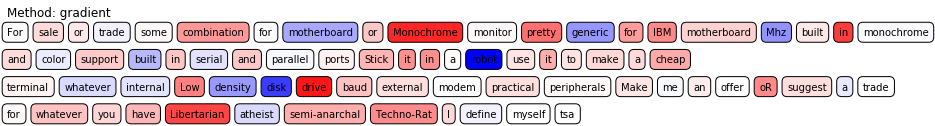

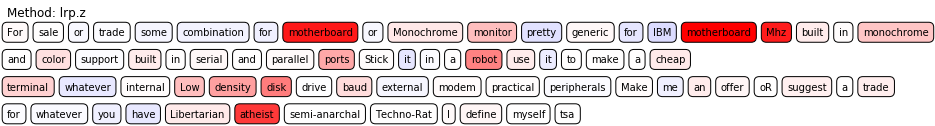

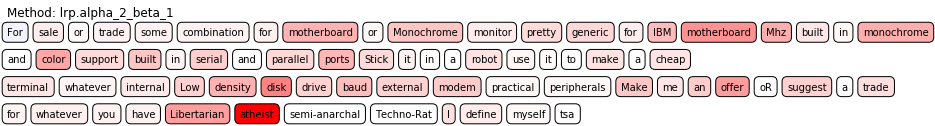

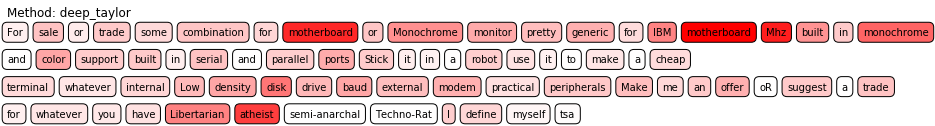

In [17]:
for i, idx in enumerate(test_sample_paths):

    words = dset.data_from_path(idx)[0]
    
    #print('Review(id=%d): %s' % (idx, ' '.join(words)))
    #_,y_true,_2 = dset[idx]
    #y_pred = test_sample_preds[i]

    #print("Pred class : %s %s" %
    #      (y_pred, '✓' if y_pred == y_true else '✗ (%s)' % y_true)
    #     )
                                
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.show()

In [18]:
def get_distortion_curve(x,maps):
    yval = [None]*len(maps)
    #print(len(maps))
    for i in range(len(maps)):
        
        yval[i] = np.zeros(51)
        n = np.random.normal(size=(32,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        #print(maps[i].shape)
        c = 0
        #print(maps[i].shape)
        with torch.no_grad():
            z = [int(f*x.shape[0]/50) for f in range(51)]
            for k in z:
                
                #print(k)
                n[:,0,order[:k],:] = x[order[:k]]
                #n[:,0,order[:k],:] = x[order[:k]]
                #print(n.shape)
                #print(x.shape)
                out = model(torch.as_tensor(n.astype(np.float32)).to(device))

                x_input = torch.as_tensor(x[None,None,:,:]).to(device, dtype = torch.float)
                x_out = model(x_input)
                highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
                
                yval[i][c] = comp_loss(out,x_out,highest_dim).data.item()
                c += 1

    return yval

In [19]:
w,x = dset.data_from_path(pths[6][6])
m = rmap[6][6]
y = get_distortion_curve(x,[m])

In [20]:
y

[array([2692.59423828, 2688.02270508, 2663.93286133, 2552.36621094,
        2474.60131836, 2387.36816406, 2307.42626953, 2169.71191406,
        2092.23168945, 2054.25732422, 1928.67529297, 1899.54870605,
        1806.41943359, 1719.39172363, 1634.37268066, 1610.21630859,
        1588.13842773, 1557.27587891, 1466.30151367, 1343.60595703,
        1329.47314453, 1271.14990234, 1231.32299805, 1145.58666992,
        1105.07861328, 1000.35858154, 1006.9432373 ,  997.74597168,
         914.88049316,  893.39105225,  813.2487793 ,  790.32458496,
         731.75341797,  684.35919189,  683.64764404,  649.91601562,
         633.62731934,  596.74615479,  577.47375488,  543.69244385,
         533.95495605,  484.39825439,  463.2633667 ,  436.79165649,
         478.26470947,  401.94638062,  419.53527832,  362.84475708,
         278.0397644 ,   98.45895386,    0.        ])]

In [21]:
y2 = get_distortion_curve(x,analysis[0,:,0])

In [22]:
y2

[array([2962.09155273, 2890.34057617, 2855.72924805, 2805.6418457 ,
        2793.47705078, 2689.91064453, 2657.36572266, 2555.27832031,
        2491.8840332 , 2461.29541016, 2425.84790039, 2400.74511719,
        2335.40234375, 2331.99584961, 2220.0637207 , 2249.68066406,
        2197.03515625, 2101.72460938, 2064.13476562, 2039.26818848,
        1990.50927734, 1949.39050293, 1896.32617188, 1664.96704102,
        1620.47753906, 1534.08911133, 1424.63745117, 1388.74291992,
        1362.69433594, 1341.02770996, 1294.81713867, 1256.08764648,
        1148.13806152, 1080.51989746, 1060.88220215,  999.02282715,
         928.20568848,  887.09716797,  892.05041504,  804.4909668 ,
         773.46112061,  747.27600098,  721.11108398,  731.17224121,
         448.89758301,  385.46636963,  329.81829834,  343.51861572,
         186.82620239,  193.70648193,    0.        ]),
 array([2929.89501953, 2897.11328125, 2831.81005859, 2767.84521484,
        2718.37207031, 2643.64794922, 2562.51879883, 2531.848

Text(0, 0.5, 'Distortion')

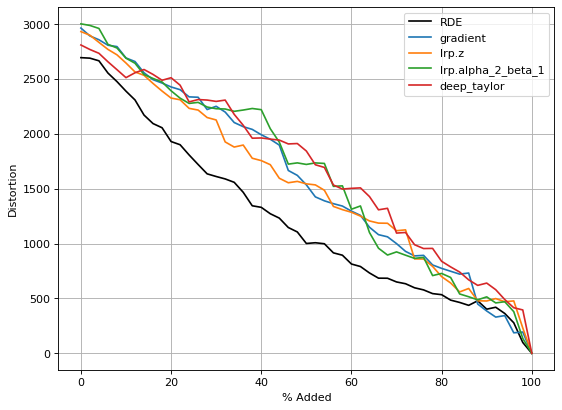

In [23]:
x_ax = list(range(51))
x_ax = [2*k for k in x_ax]
#print(x_ax)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,y[0],'black')

for i in range(len(y2)):
    plt.plot(x_ax,y2[i])
    
plt.legend(['RDE','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion')

In [24]:

test_sample_paths = []
for i in range(140):
    
    #print(i//4)
    #print(i%4)
    #print(pths[i//4][i%4])
    test_sample_paths.append(pths[i//7][i%7])

test_sample_preds = [None]*len(test_sample_paths)

analyzis = [[None]*len(analyzers)]*len(test_sample_paths)
#print(len(test_sample_paths))
for i, ridx in enumerate(test_sample_paths):
 
    #print(i)
    x = dset.data_from_path(ridx)[1]
    #print(x.shape)
    x = x.reshape((1, -1, 300,1))    
    #print(x.shape)
    #print(ridx)
    analyzis[i] = [np.zeros(x.shape[1])]*len(analyzers)
    for aidx, analyzer in enumerate(analyzers):
        
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analyzis[i][aidx] = a
        
    #print(analyzis[0][0].shape)
    

In [25]:
y=[np.zeros(51)]*140
y2 = [[np.zeros(51)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        #print(pths[j][i])
        #print(test_sample_paths[i+j*4])
        w,x = dset.data_from_path(pths[j][i])
        m = rmap[j][i]
        
        y[j*4 + i] = get_distortion_curve(x,[m])
        y2[j*4 + i] = get_distortion_curve(x,analyzis[j*7+i])

In [26]:
yt = [x[0] for x in y]
z = np.array(yt)
print(z.shape)
print(z.mean(axis=0).shape)
ym = z.mean(axis=0)

(140,)
(51,)


In [27]:
print(np.array(y2).shape)
z = np.array(y2)
y2m = z.mean(axis=0)
print(y2m.shape)

(140, 4, 51)
(4, 51)


Text(0, 0.5, 'Distortion')

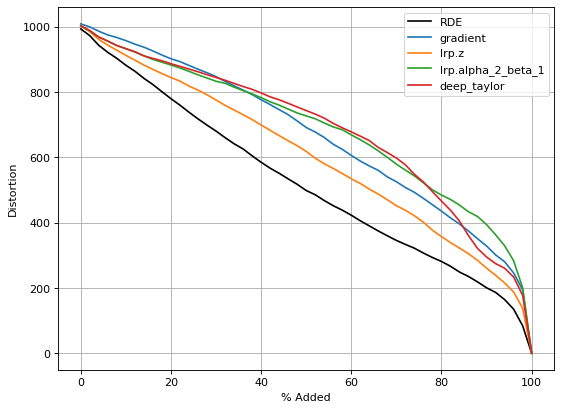

In [28]:
x_ax = list(range(51))
x_ax = [2*k for k in x_ax]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,ym,'black')

for i in range(y2m.shape[0]):
    plt.plot(x_ax,y2m[i])
    
plt.legend(['RDE','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion')

In [29]:
'''
indx = sorted(range(len(rmap[0,:,0])), key=lambda k: rmap[0,k,0])
wd = [e[i] for i in indx]
wd = wd[::-1]
wd = wd[:6]
rmap = rmap[0,:,0]
smap = [rmap[i] for i in indx]
smap = smap[::-1]
smap = smap[:6]

import seaborn as sns
import pandas as pd

x = pd.DataFrame(wd,columns=['Words'])
x['RMap'] = smap
print(x.head())
sns.set(style="whitegrid")


ax = sns.barplot(x="Words", y="RMap", data=x)
'''

###### ACC GRAPH
BTCH = 256

def get_acc(x,target,maps):
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        n = np.random.normal(size=(BTCH,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
                
        with torch.no_grad():
            for k in range(1,11):
                
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                #print(temp)
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

In [30]:
w,x = dset.data_from_path(pths[6][6])
m = rmap[6][6]
y = get_acc(x,6,[m])
print(y)

[array([1.        , 0.47265625, 0.203125  , 0.09375   , 0.046875  ,
       0.01953125, 0.046875  , 0.04296875, 0.02734375, 0.02734375,
       0.015625  ])]


In [31]:
y_acc=[np.zeros(11)]*140
y2_acc = [[np.zeros(11)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        #print(pths[j][i])
        #print(test_sample_paths[i+j*4])
        w,x = dset.data_from_path(pths[j][i])
        m = rmap[j][i]
        y_acc[j*4 + i] = get_acc(x,j,[m])
        y2_acc[j*4 + i] = get_acc(x,j,analyzis[j*7+i])
        

In [32]:
yt = [x[0] for x in y_acc]
z = np.array(yt)
print(z.shape)
print(z.mean(axis=0).shape)
yam = z.mean(axis=0)

print(np.array(y2_acc).shape)
z = np.array(y2_acc)
y2am = z.mean(axis=0)
print(y2am.shape)


(140,)
(11,)
(140, 4, 11)
(4, 11)


Text(0, 0.5, 'Distortion')

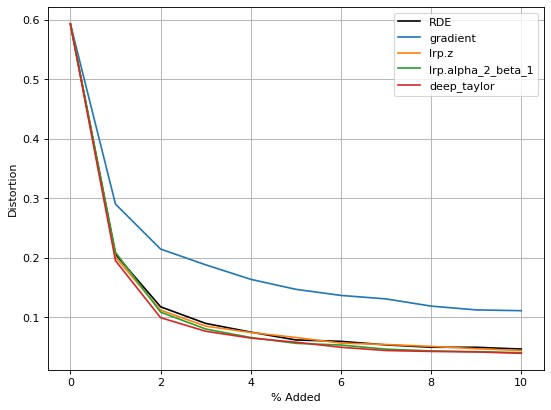

In [33]:


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(yam,'black')

for i in range(y2am.shape[0]):
    plt.plot(y2am[i])
    
plt.legend(['RDE','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion')